# Model Independent Analysis

This notebook will investigate the fixation distributions generated by examples/example4_new/addm_gen_data.ipynb using model independent analyses as described by Eum et al. (2023).

### Load the data

In [1]:
import pickle
import numpy as np

data = pickle.load(open("examples/example4_new/new_addm_data_20260202-022735.pkl", "rb"))

DATA_TYPE = np.float64

a = data["a"]
b = data["b"]
x0 = data["x0"]
eta_true = data["eta"]
kappa_true = data["kappa"]
r1_data = data["r1_data"]
r2_data = data["r2_data"]
flag_data = data["flag_data"].astype(np.int32)

sigma = data["sigma"]
T = data["T"]

mu1_true_data = kappa_true * (r1_data - eta_true * r2_data)
mu2_true_data = kappa_true * (eta_true * r1_data - r2_data)

mu_true_data = data["mu_array_padded_data"].astype(DATA_TYPE)
sacc_data = data["sacc_array_padded_data"].astype(DATA_TYPE)
length_data = data["d_data"].astype(np.int32)
rt_data = data["decision_data"][:, 0].astype(DATA_TYPE)
choice_data = data["decision_data"][:, 1].astype(np.int32)

num_data, max_d = mu_true_data.shape

In [2]:
mu_true_data[0]

array([ 0.95, -0.1 ,  0.95, -0.1 ,  0.95, -0.1 ,  0.95,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ])

In Eum et al. (2023), drift is possibly established as 3 ($\frac{0.003}{0.001}$), theta as 0.5, and noise as about 0.7 ($\frac{0.022}{\sqrt{0.001}}$). In efficient-fpt, these variables are formalized as drift $\mapsto$ kappa, theta $\mapsto$ eta, and noise is still sigma. The transformation is direct, so this makes analysis simple. What is difficult is the way saccades are formalized within the model. Liu et al. (2025) ignore fixations on the basis that they are instantaneous. Thus, the array representing saccades is just a flag for instantaneous change for fixations. Stages are left-inclusive right-exclusive.

A useful thing to have would be a mapping from the `sacc_data`, `mu_true_data` to fixation tuples given a dt. `sacc_data` is measured in seconds and padded with 0's after the trial ends up to a length of 13. Similarly, `mu_true_data` conveniently provides relevant readings for drift rate for a given stage padded with 0's after the trial ends up to a length of 13. 

Now, given the large eta in this simulated trial, it is possible for evidence to accumulate in a direction opposite to attention. Thus, we use flag to find the location to which the first fixation is directed. There is no simulated left fixation first bias within flag. In a sample of 100000 trials, 50030 were left fixation first.

In [3]:
from math import ceil, floor

def expand_fixations(sacc_data, flag_data, rt_data, dt):
    """
    Parameters
    ----------
    sacc_data : list of 1D np.ndarray
        saccade times per trial (seconds)
    flag_data : 1D np.ndarray
        initial fixation per trial (0/1 or similar)
    rt_data : 1D np.ndarray
        reaction time per trial (seconds)
    dt : float
        timestep size (seconds)

    Returns
    -------
    array
        Each element is a tuple of fixation locations for one trial
    """
    all_trials = []

    for saccs, start_fix, rt in zip(sacc_data, flag_data, rt_data):

        # number of discrete timesteps (inclusive rt)
        fix_len = int(floor(rt / dt)) + 1

        # initialize fixation array
        fix = np.full(fix_len, start_fix)

        if len(saccs) > 0:
            # convert saccade times to indices
            switch_idxs = [int(ceil(s / dt)) for s in saccs]

            # apply alternating flips
            for idx in switch_idxs[1:]:
                if idx >= fix_len or idx <= 0:
                    continue
                fix[idx:] = 1 - fix[idx]

        all_trials.append(tuple(int(x) for x in fix))

    return all_trials

In [4]:
expanded_fixations = expand_fixations(sacc_data, flag_data, rt_data, 0.001)

In [5]:
import pandas as pd

efpt_fixations = [tuple(x + 1 for x in t) for t in expanded_fixations]

efpt_df = pd.DataFrame({
    'sub_id': 'empirical_efpt',
    'trial': range(1, num_data + 1),
    'avgWTP_left': r1_data,
    'avgWTP_right': r2_data,
    'choice': (1 - choice_data) // 2,
    'RT': rt_data * 1000,
    'fixation': efpt_fixations
})

efpt_df.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fixation
0,empirical_efpt,1,4.0,3.0,0,4173.195,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,empirical_efpt,2,3.0,1.0,0,1738.365,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,empirical_efpt,3,4.0,1.0,0,865.665,"(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,empirical_efpt,4,5.0,4.0,0,553.455,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,empirical_efpt,5,1.0,3.0,1,388.735,"(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."


In [6]:
print(f'Representative fixations: {expanded_fixations[0][::400]}') 
print(f"Corresponding drift rates: {[f'{mu:.2f}' for mu in mu_true_data[0] if mu != 0]}")
print(f'Length of fixations: {len(expanded_fixations[0])}')
print(f'True RT: {rt_data[0]}')

Representative fixations: (0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0)
Corresponding drift rates: ['0.95', '-0.10', '0.95', '-0.10', '0.95', '-0.10', '0.95']
Length of fixations: 4174
True RT: 4.17319500001118


The inverse will also be useful to migrate old data into new.

In [7]:
def compress_fixations(fixation_trials, max_d, dt):
    """
    Inverse of expand_fixations (up to dt resolution),
    with zero-padded saccade arrays, using
    left-inclusive / right-exclusive convention.

    Parameters
    ----------
    fixation_trials : iterable of tuple[int]
        Output of expand_fixations
    dt : float
        timestep size (seconds)
    max_d : int
        maximum number of saccades per trial (including padding)

    Returns
    -------
    sacc_data : list of np.ndarray, shape (max_d,)
        Zero-padded saccade times (seconds)
    flag_data : np.ndarray
        Initial fixation per trial
    rt_data : np.ndarray
        Reaction times per trial (seconds)
    """
    sacc_data = []
    flag_data = []
    rt_data = []

    eps = 1e-12

    for fix in fixation_trials:
        fix = np.asarray(fix, dtype=int)

        # initial fixation
        flag_data.append(fix[0])

        # reaction time (inclusive)
        rt_data.append((len(fix) - 1) * dt)

        # detect fixation switches (indices)
        switch_idxs = np.where(fix[1:] != fix[:-1])[0] + 1

        # map indices -> times inside ((k-1)dt, kdt]
        sacc_times = switch_idxs * dt - eps

        # prepend true start time (left-inclusive)
        sacc_times = np.insert(sacc_times, 0, 0.0)

        # pad with zeros up to max_d
        padded = np.zeros(max_d, dtype=float)
        n = min(len(sacc_times), max_d)
        padded[:n] = sacc_times[:n]

        sacc_data.append(padded)

    return sacc_data, np.array(flag_data), np.array(rt_data)


In [8]:
tsacc_data, tflag_data, trt_data = compress_fixations(expanded_fixations, max_d, 0.001)

In [9]:
print(f'Transformed sacc_data: {tsacc_data[0]}')
print(f"True sacc_data: {[f'{sacc:.4f}' for sacc in sacc_data[0]]}")

Transformed sacc_data: [0.    1.022 1.799 2.187 2.903 3.335 3.729 0.    0.    0.    0.    0.
 0.   ]
True sacc_data: ['0.0000', '1.0214', '1.7983', '2.1863', '2.9021', '3.3346', '3.7287', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000']


As we see, the transformation incorporate left-inclusive and right-exclusive timing. However, the inverse transformation is only able to recover timing up to dt. Since the model makes no claim about sub dt-timings (researchers may choose to change dt depending on their needs), we can move forward assuming that both functions transform efficient-fpt data into PyDDM data and vice versa.

### Model independent analysis

I forgot to push `pyddm.preprocessing` onto my github branch of pyddm. So, I have restored the inverse of `derasterize_data` from `data_transformation.ipynb`.

In [10]:
import pandas as pd

def rasterize_data(
    df: pd.DataFrame,
    subject_col: str,
    trial_col: str,
    seq_col: str = "fixation",
    fill_codes: set = {0, 4},
    start_col: str = "fix_start",
    end_col: str = "fix_end",
    loc_col: str = "fix_location",
    fixnum_col: str | None = None,
    keep_cols: list[str] | None = None,
) -> pd.DataFrame:
    """
    Expand per-(subject, trial) fixation sequences into fixation-level rows.
    Zero-valued segments are treated as transitions and excluded.
    """

    df = df.copy()

    if keep_cols is None:
        keep_cols = [
            c for c in df.columns
            if c not in {subject_col, trial_col, seq_col}
        ]

    rows = []

    for _, row in df.iterrows():
        seq = np.asarray(row[seq_col])

        changes = np.diff(seq, prepend=seq[0])
        starts = np.where(changes != 0)[0]

        fix_num = 0

        for i, start_idx in enumerate(starts):
            loc = seq[start_idx]

            end_idx = (
                starts[i + 1]
                if i + 1 < len(starts)
                else len(seq)
            )

            # Skip transitions
            if loc in fill_codes:
                continue

            data = {
                subject_col: row[subject_col],
                trial_col: row[trial_col],
                start_col: start_idx,
                end_col: end_idx,
                loc_col: loc,
            }

            if fixnum_col is not None:
                data[fixnum_col] = fix_num
                fix_num += 1

            for col in keep_cols:
                data[col] = row[col]

            rows.append(data)

    return pd.DataFrame(rows)

In [11]:
from ast import literal_eval

df_raw = pd.read_csv('/Users/bchien37/Desktop/Enkavilab/DDM/1ms_trial_data.csv')
df_raw['choice'] = df_raw['choice'].map({'left':0,'right':1})
df_raw['RT'] = df_raw['RT']*1000 # adjustment for RT
df_raw['fixation'] = df_raw['fixation'].apply(literal_eval)

to_drop = pd.read_csv("/Users/bchien37/Desktop/Enkavilab/DDM/dropped_trials.csv").rename(columns={"parcode": "sub_id"})

df = df_raw[
    ~df_raw.set_index(["sub_id", "trial"]).index.isin(
        to_drop.set_index(["sub_id", "trial"]).index
    )
]

samples_rasterized = rasterize_data(df, subject_col='sub_id',trial_col='trial',seq_col='fixation')

In [19]:
df.head()

,sub_id,trial,hidden,avgWTP_left,avgWTP_right,choice,RT,fixation
0,329,1,True,1.00,5.0,1,1723.0,"(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,329,2,True,3.00,5.0,0,2573.0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,329,3,True,4.25,1.0,0,1775.0,"(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
3,329,4,True,3.50,1.0,0,1903.0,"(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
4,329,5,True,1.50,1.0,0,1863.0,"(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [12]:
samples_rasterized = samples_rasterized.loc[:, ['sub_id', 'trial', 'hidden', 'avgWTP_left', 'avgWTP_right', 'choice', 'RT', 'fix_start', 'fix_end', 'fix_location']]
samples_rasterized['fix_dur'] = samples_rasterized.apply(
    lambda r: r['fix_end'] - r['fix_start'],
    axis=1
)

samples_rasterized['fix_num'] = (
    samples_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount() + 1
)

samples_rasterized['fix_num_rev'] = (
    samples_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount(ascending=False) + 1
)
samples_rasterized.head()

,sub_id,trial,hidden,avgWTP_left,avgWTP_right,choice,RT,fix_start,fix_end,fix_location,fix_dur,fix_num,fix_num_rev
0,329,1,True,1.0,5.0,1,1723.0,210,776,1,566,1,2
1,329,1,True,1.0,5.0,1,1723.0,794,1723,2,929,2,1
2,329,2,True,3.0,5.0,0,2573.0,396,1151,1,755,1,3
3,329,2,True,3.0,5.0,0,2573.0,1169,2073,2,904,2,2
4,329,2,True,3.0,5.0,0,2573.0,2089,2573,1,484,3,1


In [13]:
import os, sys

DDM_dir = os.path.abspath('/Users/bchien37/Desktop/Enkavilab/DDM')
sys.path.append(DDM_dir)

from mfa import plot_basic_psychometrics, plot_fixation_properties

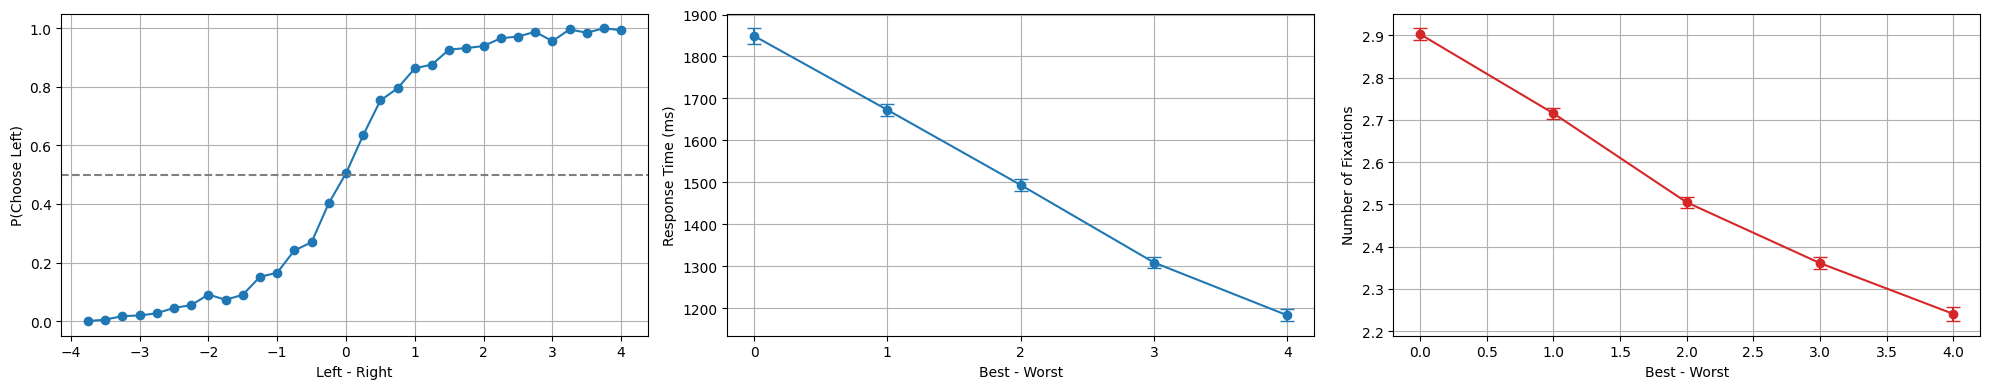

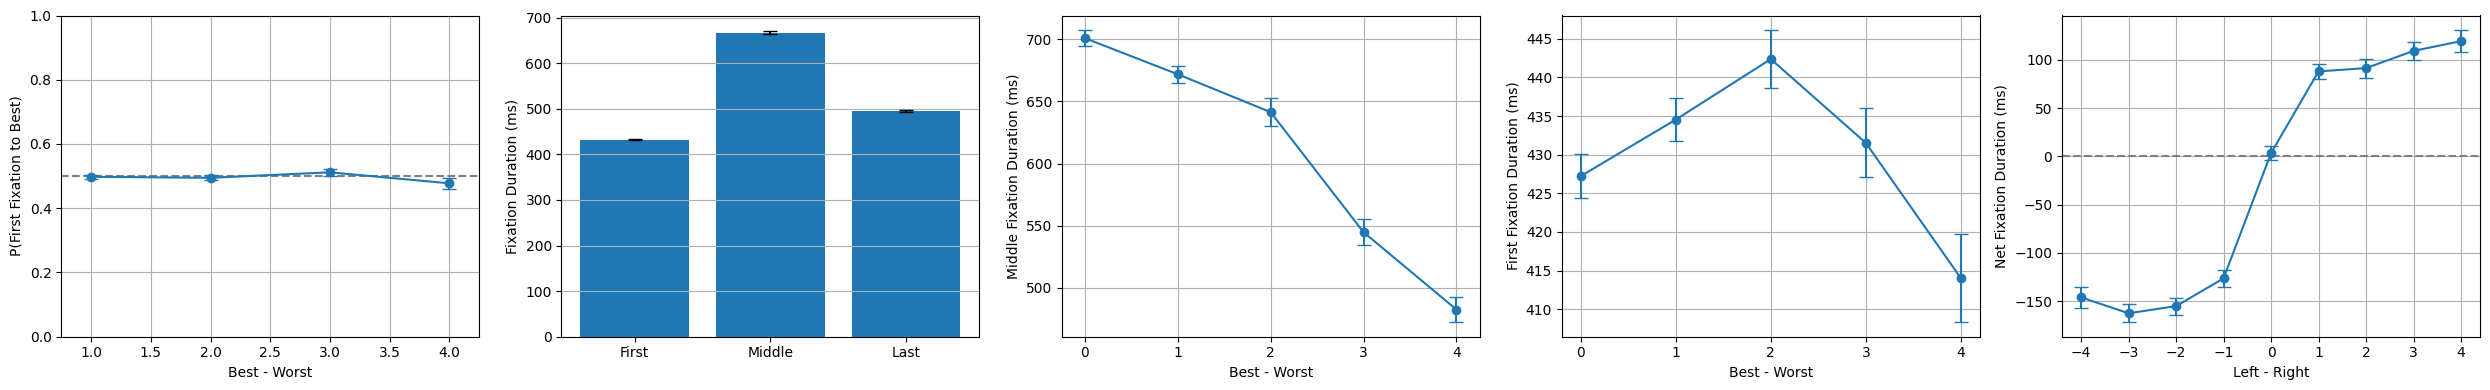

In [14]:
plot_basic_psychometrics(samples_rasterized)
plot_fixation_properties(samples_rasterized)

Now that we know that this function is good, we will perform it on the transformed effficient-fpt fixations.

In [15]:
df.head()

,sub_id,trial,hidden,avgWTP_left,avgWTP_right,choice,RT,fixation
0,329,1,True,1.00,5.0,1,1723.0,"(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,329,2,True,3.00,5.0,0,2573.0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,329,3,True,4.25,1.0,0,1775.0,"(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
3,329,4,True,3.50,1.0,0,1903.0,"(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
4,329,5,True,1.50,1.0,0,1863.0,"(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [16]:
efpt_df = pd.DataFrame({
    'sub_id': 'efpt_sim',
    'trial': range(1, num_data + 1),
    'avgWTP_left': r1_data,
    'avgWTP_right': r2_data,
    'choice': (1 - choice_data) // 2,
    'RT': rt_data * 1000,
    'fixation': efpt_fixations
})

efpt_df.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fixation
0,efpt_sim,1,4.0,3.0,0,4173.195,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,efpt_sim,2,3.0,1.0,0,1738.365,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,efpt_sim,3,4.0,1.0,0,865.665,"(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,efpt_sim,4,5.0,4.0,0,553.455,"(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,efpt_sim,5,1.0,3.0,1,388.735,"(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."


In [17]:
efpt_rasterized = rasterize_data(efpt_df, subject_col='sub_id',trial_col='trial',seq_col='fixation')
efpt_rasterized = efpt_rasterized.loc[:, ['sub_id', 'trial', 'avgWTP_left', 'avgWTP_right', 'choice', 'RT', 'fix_start', 'fix_end', 'fix_location']]
efpt_rasterized['fix_dur'] = efpt_rasterized.apply(
    lambda r: r['fix_end'] - r['fix_start'],
    axis=1
)

efpt_rasterized['fix_num'] = (
    efpt_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount() + 1
)

efpt_rasterized['fix_num_rev'] = (
    efpt_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount(ascending=False) + 1
)
efpt_rasterized.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fix_start,fix_end,fix_location,fix_dur,fix_num,fix_num_rev
0,efpt_sim,1,4.0,3.0,0,4173.195,1022,1799,2,777,1,6
1,efpt_sim,1,4.0,3.0,0,4173.195,1799,2187,1,388,2,5
2,efpt_sim,1,4.0,3.0,0,4173.195,2187,2903,2,716,3,4
3,efpt_sim,1,4.0,3.0,0,4173.195,2903,3335,1,432,4,3
4,efpt_sim,1,4.0,3.0,0,4173.195,3335,3729,2,394,5,2


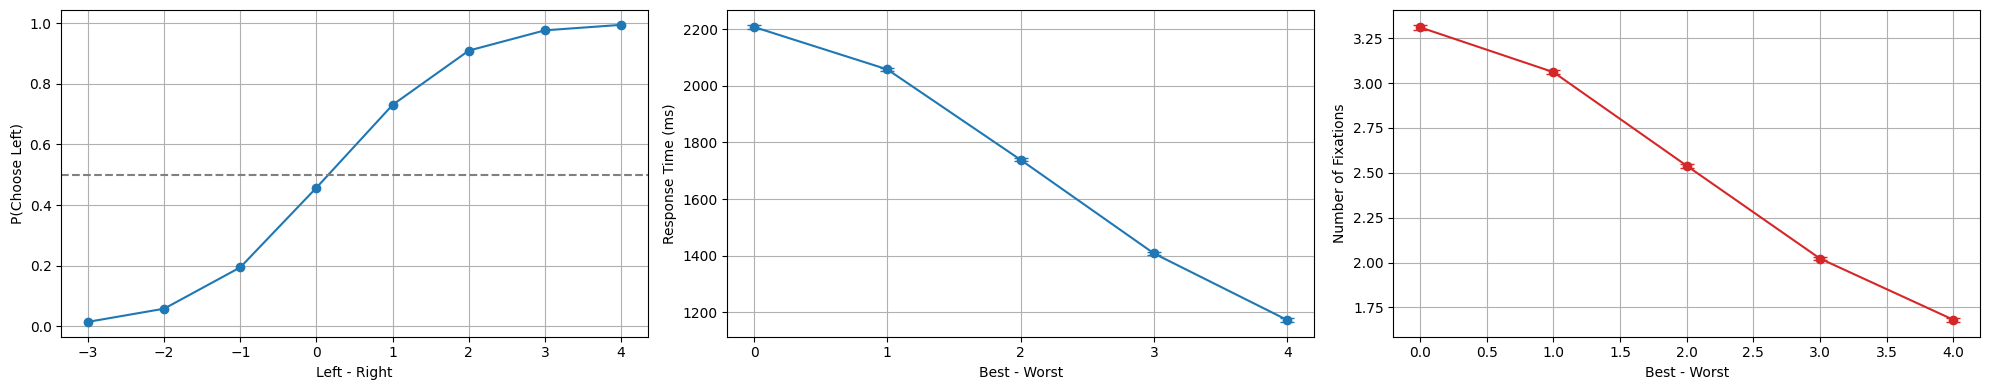

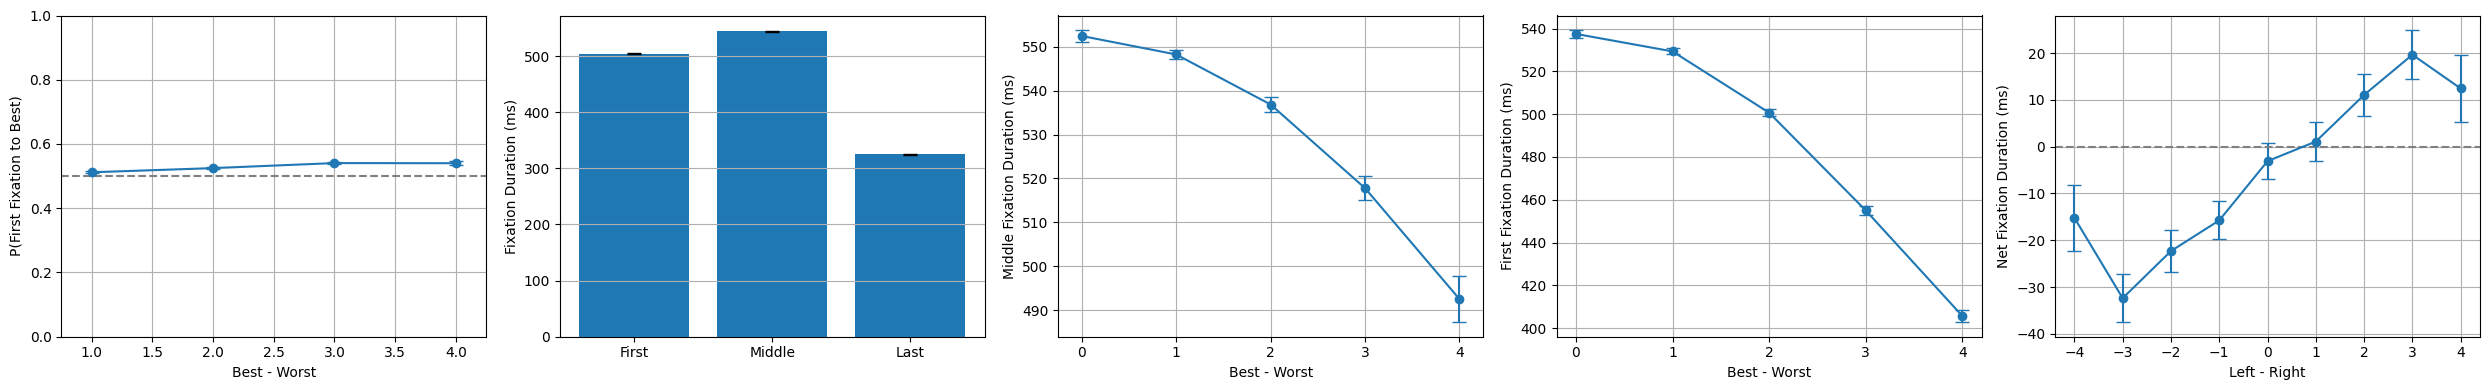

In [18]:
plot_basic_psychometrics(efpt_rasterized)
plot_fixation_properties(efpt_rasterized)

Since the original data was generated with some bias $x0 \neq 0$, $\mathbb{P}(\text{First Fixation to Best})$ is slightly skewed off 0.5. We can also comment on the middle fixations being longer than the first fixation because all fixations were sampled iid. We'd expect only the last fixations to have truncated durations, which they do exhibit. The net fixation curve has an interesting dynamic—I wonder if it is because of experimental design. Although the effect is muted in Eum et al.'s (2023) model independent analyses, there also seems to be a big of a reversal at the extreme value differences for net fixation duration. I surmise that this is because in trials with relatively "easy" decisions, the amount of time we need to decide is shorter, and with a large theta, net fixation duration is less meaningful.